# Nowcasting for multiple states

In [19]:
# autoreload 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import datetime
import arviz
import seaborn as sns
import os
sns.set()

In [21]:
from nowcasting_functions import *

In [22]:
cwd = os.getcwd()

You can add states below, but plotting is set up for 12 subplots

In [23]:
states = ['AC', 'SP', 'PA', 'DF', 'RO', 'RR', 'CE', 'PE', 'RJ', 'SC', 'AM', 'Brazil']

### Load and prepare the data

In [24]:
# Load the data
data_new = pd.read_csv('data/df_SIVEP_nowcast_allStates_08-02-2021.csv')
print("First date:", data_new.Date.values[0])
print("Last date:", data_new.Date.values[-1])
data_new

First date: 2019-12-31
Last date: 2021-02-07


,State,Date,Deaths,Release,Date_index,Release_index
0,SC,2019-12-31,1,2020-07-07,-1,0
1,PE,2020-01-02,1,2020-07-07,1,0
2,SP,2020-01-02,1,2020-07-07,1,0
3,AM,2020-01-03,1,2020-07-07,2,0
4,PR,2020-01-03,1,2020-07-07,2,0
...,...,...,...,...,...,...
191453,RO,2021-02-07,1,2021-02-08,403,216
191454,RS,2021-02-07,5,2021-02-08,403,216
191455,SC,2021-02-07,5,2021-02-08,403,216
191456,SE,2021-02-07,2,2021-02-08,403,216


In [25]:
data_new[data_new["State"] == "SC"]

,State,Date,Deaths,Release,Date_index,Release_index
0,SC,2019-12-31,1,2020-07-07,-1,0
48,SC,2020-01-16,1,2020-07-07,15,0
65,SC,2020-01-19,1,2020-07-07,18,0
185,SC,2020-02-16,1,2020-07-07,46,0
213,SC,2020-02-21,1,2020-07-07,51,0
...,...,...,...,...,...,...
191363,SC,2021-02-03,26,2021-02-08,399,216
191389,SC,2021-02-04,13,2021-02-08,400,216
191415,SC,2021-02-05,16,2021-02-08,401,216
191439,SC,2021-02-06,11,2021-02-08,402,216


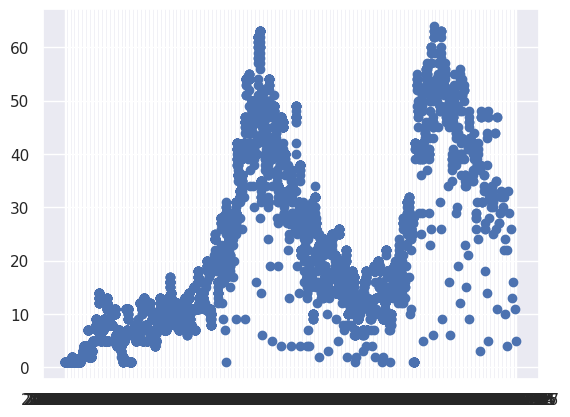

In [26]:
plt.scatter(data_new[data_new["State"] == "SC"]["Date"], data_new[data_new["State"] == "SC"]["Deaths"])

In [56]:
data_new.Release.unique()

array(['2020-07-07', '2020-07-14', '2020-07-21', '2020-07-29',
       '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
       '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
       '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
       '2020-10-26', '2020-11-02', '2020-11-10', '2020-11-16',
       '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
       '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
       '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08'],
      dtype=object)

In [57]:
# Prepare the data for nowcast
data_new['Release_index'] = data_new.Release.astype('category').cat.codes
# data_new = data_new[data_new['Date'] >= '2020-06-30'] # cut off early days as they are less relevant
# data_new = data_new[data_new['Release'] >= '2020-06-30'] # cut off early days as they are less relevant

In [58]:
# check if all states of interest are in the df
set(states[:-1]).issubset(list(data_new.State.unique()))

True

### Get the STAN model

In [23]:
model = pystan.StanModel(file=cwd+'/stan_models/4comp_longshort_SE.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fc993fd7bf0aedb8928d1ca1f5149e1 NOW.
In file included from /home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1913,
                 from /home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12,
                 from /home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/numpy/_core/include/numpy/arrayobject.h:5,
                 from /tmp/tmpftm67zqt/stanfit4anon_model_5fc993fd7bf0aedb8928d1ca1f5149e1_5216393310797168031.cpp:1315:
/home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/pystan/stan

Model compiled


In [17]:
def get_state_data(df, state):
    df_state = df.copy()
    if state == 'Brazil':
        # need to merge!!!!!!
        df_state.drop(columns=['State'], inplace=True)
        columns = list(df_state.columns)
        columns.remove('Deaths')
        df_state = df_state.groupby(columns, as_index=False)['Deaths'].sum()
        return df_state
    return df_state[df_state['State'] == state]

def do_nowcast_for_state(df, state, model):
    data = get_state_data(df, state)
    fit, results = fit_model(data, precompiled=False, modelname=model, date_nowcast=None,
              maxD=10, iters=1000, warmup=400, chains=4, adapt_delta=0.9,
              max_treedepth=12, seed=9876,
              pickle_run=False, save=False, savepath='')
    return fit, results

In [27]:
get_state_data(data_new.copy(), 'Brazil')

,Date,Release,Date_index,Release_index,Deaths
0,2020-06-30,2020-07-07,181,0,722
1,2020-06-30,2020-07-14,181,1,933
2,2020-06-30,2020-07-21,181,2,1025
3,2020-06-30,2020-07-29,181,3,1091
4,2020-06-30,2020-08-03,181,4,1116
...,...,...,...,...,...
3686,2021-02-03,2021-02-08,399,31,621
3687,2021-02-04,2021-02-08,400,31,486
3688,2021-02-05,2021-02-08,401,31,353
3689,2021-02-06,2021-02-08,402,31,225


### Do the nowcasting for each state

In [41]:
data_new[data_new['State'] == 'AC']

,State,Date,Deaths,Release,Date_index,Release_index
2974,AC,2020-06-30,2,2020-07-07,181,0
3000,AC,2020-07-01,1,2020-07-07,182,0
3027,AC,2020-07-02,1,2020-07-07,183,0
6150,AC,2020-06-30,5,2020-07-14,181,1
6176,AC,2020-07-01,7,2020-07-14,182,1
...,...,...,...,...,...,...
190899,AC,2021-01-17,1,2021-02-08,382,31
190952,AC,2021-01-19,1,2021-02-08,384,31
191004,AC,2021-01-21,1,2021-02-08,386,31
191109,AC,2021-01-25,2,2021-02-08,390,31


In [28]:
fits = {}
results = {}

for s in states:
    print('Nowcasting for ' + s)
    fit, result = do_nowcast_for_state(data_new.copy(), s, model)
    fits.update({s: fit})
    results.update({s: result})
    
print('All nowcasting completed')

Nowcasting for AC


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000413 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000557 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.57 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000332 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000466 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.66 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is inf, but must be finite!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is inf, but must be finite!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis 

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is inf, but must be finite!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is inf, but must be finite!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [10

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 5.26632 seconds (Warm-up)
               11.5761 seconds (Sampling)
               16.8424 seconds (Total)

Nowcasting for SP


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.00078 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000728 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000764 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000738 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.38 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in '4comp_longshort_SE.stan' at line 112)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in '4comp_longshort_SE.stan' at line 112)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Met

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 1.81922e+09, but must be less than 1.07374e+09  (in '4comp_longshort_SE.stan' at line 170)

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 1.64787e+12, but must be less than 1.07374e+09  (in '4comp_longshort_SE.stan' at line 170)

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for PA


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000653 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.53 seconds.

Adjust your expectations accordingly!



Gradient evaluation took 0.0007 seconds
1000 transitions using 10 leapfrog steps per transition would take 7 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000714 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.14 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001167 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.67 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is inf, but must be finite!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposa

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for DF


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000842 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.42 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000608 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000629 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.29 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000682 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.82 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal i

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RO


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000608 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.08 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000655 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.55 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000681 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.81 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000653 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.53 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is 

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RR


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)




Gradient evaluation took 0.000415 secondsGradient evaluation took 0.000406 seconds

1000 transitions using 10 leapfrog steps per transition would take 4.15 seconds.1000 transitions using 10 leapfrog steps per transition would take 4.06 seconds.

Adjust your expectations accordingly!Adjust your expectations accordingly!






Gradient evaluation took 0.000646 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000341 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.41 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is inf, but must be finite!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposa

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 7.79257 seconds (Warm-up)
               10.2904 seconds (Sampling)
               18.0829 seconds (Total)

Nowcasting for CE


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000613 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000578 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000616 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.16 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000579 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.79 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal i

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for PE


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000711 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.11 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000675 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.75 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000874 seconds
Gradient evaluation took 0.000875 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.74 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 8.75 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal i

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Ite

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RJ


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000649 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000642 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.42 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000612 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.12 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000897 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.97 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal i

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
I

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for SC


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000974 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.74 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000664 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000614 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.14 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: Matrix m is not positive definite  (in '4comp_longshort_SE.stan' at line 111)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: Matrix m is not positive definite  (in '4comp_longshort_SE.stan' at line 111)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be reject

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for AM


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000648 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000808 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000734 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000646 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.46 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be > 0!  (in '4comp_longshort_SE.stan' at line 158)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal i

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for Brazil


/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000637 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.37 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000617 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.17 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000628 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00077 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.7 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in '4comp_longshort_SE.stan' at line 111)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in '4comp_longshort_SE.stan' at line 111)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropo

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 3.88269e+18, but must be less than 1.07374e+09  (in '4comp_longshort_SE.stan' at line 170)

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 3.75911e+09, but must be less than 1.07374e+09  (in '4comp_longshort_SE.stan' at line 170)

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 5.95022e+27, but must be less than 1.07374e+09  (in '4comp_longshort_SE.stan' at line 170)

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 2.49572e+22, but must be less than 1.07374e+09  (in '4comp_longshort_SE.stan' at line 170)

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


All nowcasting completed


In [30]:
results.keys()

dict_keys(['AC', 'SP', 'PA', 'DF', 'RO', 'RR', 'CE', 'PE', 'RJ', 'SC', 'AM', 'Brazil'])

In [11]:
# for each state plot the results
def plot_for_state(df, state, result_nowcast, show_x=True, show_y=True, show_legend=True):
    state_df = get_state_data(df, state)
    date_nowcast = state_df['Date'].values[-1]
    reported, _ = nowcasting_prep(state_df, date_nowcast, maxD=10)
    nowcasted = result_nowcast[state]
    
    x = reported.index + 27

    plt.fill_between(x, y1=nowcasted['q025'].values,
                     y2=nowcasted['q975'].values, alpha = 0.3, 
                     label = '95% CrI', color = 'orange')
    
    plt.fill_between(x, y1=nowcasted['q25'].values,
                     y2=nowcasted['q75'].values, alpha = 0.6, 
                     label = '50% CrI', color = 'orange')

    plt.scatter(reported.index+27, reported.all_deaths.values, 
             label = 'reported', color='blue')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if show_x:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_y:
        plt.ylabel('Number of deaths per week', fontsize=16)
    if show_legend:
        plt.legend(loc="upper right", fontsize=12)
    
    plt.title(state, fontsize=20)

### Plot the results

In [31]:
states_sorted = states.copy()
states_sorted.remove('Brazil')
states_sorted.sort()
states_sorted.append('Brazil')
states_sorted

['AC', 'AM', 'CE', 'DF', 'PA', 'PE', 'RJ', 'RO', 'RR', 'SC', 'SP', 'Brazil']

/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)
/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)
/data/hbz15/HIPPO-SVGP/GP_nowcasting/nowcasting_functions.py:215: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call 

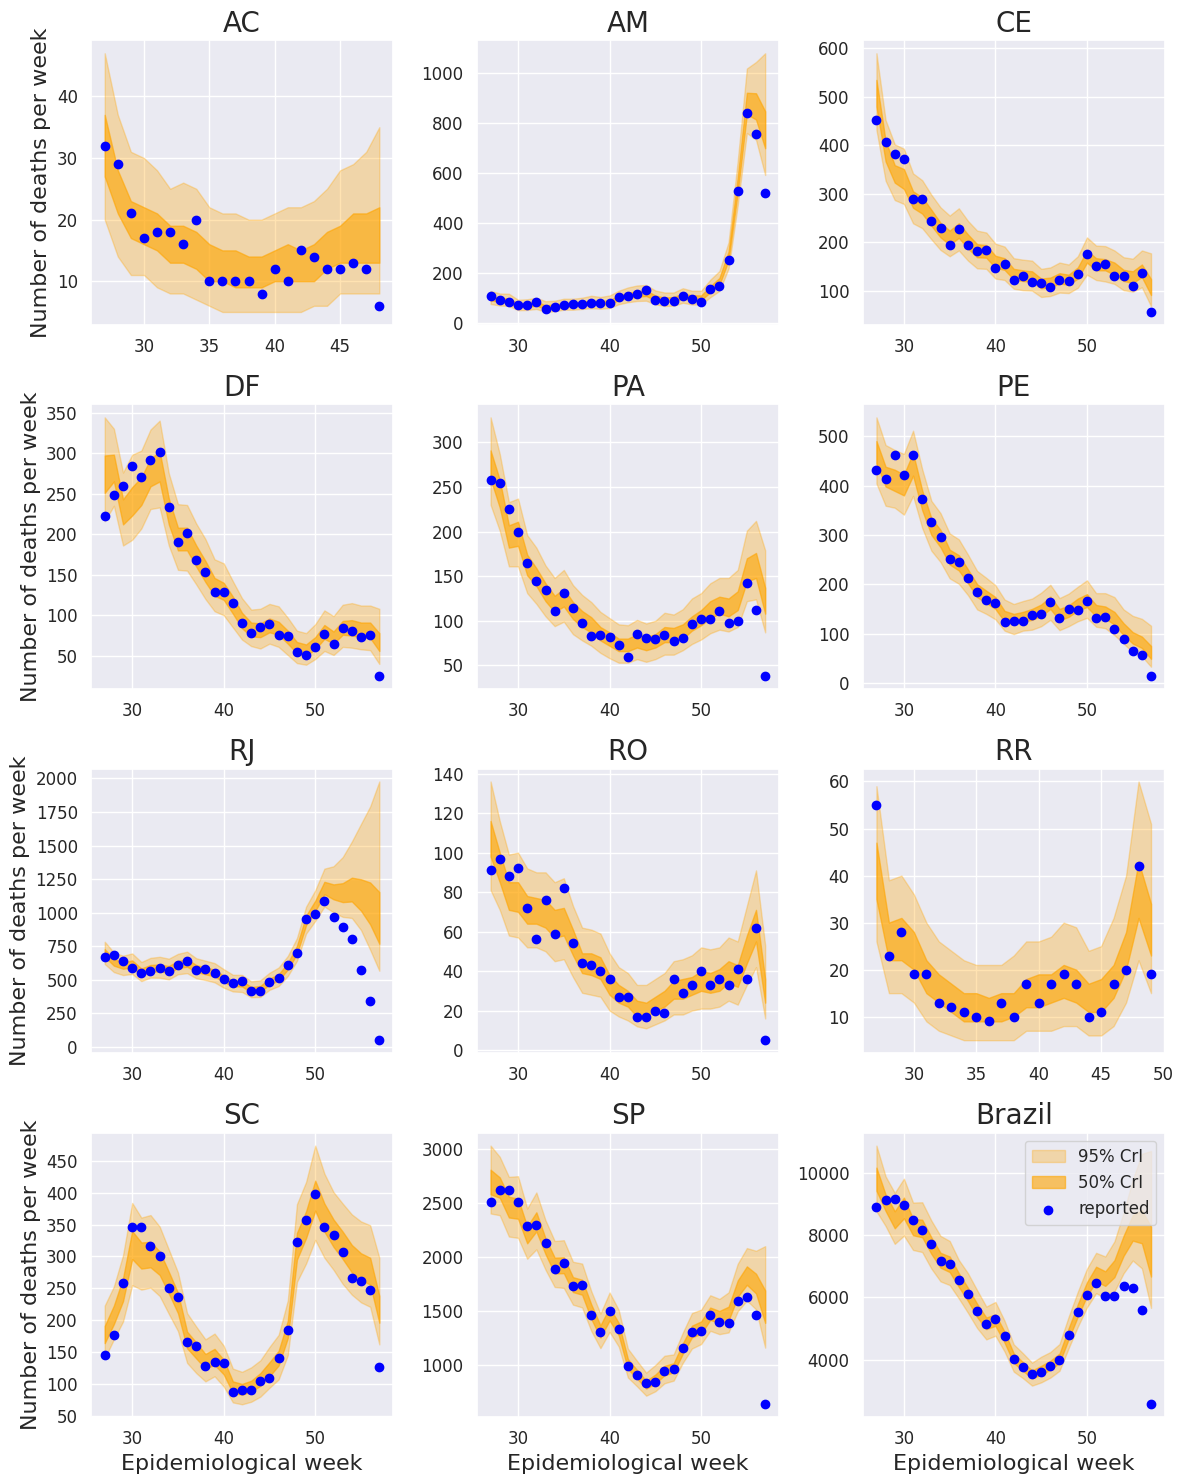

In [33]:
plt.figure(figsize=(12,15))

# for i in range(len(states)):
for i in range(len(states_sorted)):
    show_legend = False
    show_x = False
    show_y = False
    if i+1 == len(states):
        show_legend = True
    if i+1 in [1,4,7,10]:
        show_y = True
    if i+1 in [10, 11, 12]:
        show_x = True
    plt.subplot(4,3,i+1)
#     plot_for_state(data_new, states[i], results, show_x, show_y, show_legend)
    plot_for_state(data_new, states_sorted[i], results, show_x, show_y, show_legend)
plt.tight_layout()

plt.show()

## Alternative results with the NobBS model https://doi.org/10.1371/journal.pcbi.1007735

In [9]:
model_nobbs = pystan.StanModel(file=cwd+'/stan_models/nobbs.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50ab4c0f87d41cc6e3e4c401019d3bf2 NOW.
In file included from /home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1913,
                 from /home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12,
                 from /home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/numpy/_core/include/numpy/arrayobject.h:5,
                 from /tmp/tmp3rk4l6rv/stanfit4anon_model_50ab4c0f87d41cc6e3e4c401019d3bf2_7191150001549522449.cpp:1315:
/home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /home/hbz15/HIPPO-SVGP/.env/lib/python3.10/site-packages/pystan/stan

Model compiled


In [10]:
def get_state_data(df, state):
    df_state = df.copy()
    if state == 'Brazil':
        # need to merge!!!!!!
        df_state.drop(columns=['State'], inplace=True)
        columns = list(df_state.columns)
        columns.remove('Deaths')
        df_state = df_state.groupby(columns, as_index=False)['Deaths'].sum()
        return df_state
    return df_state[df_state['State'] == state]

def do_nowcast_daily_for_state(df, state, model):
    data = get_state_data(df, state)
    fit, results, delays_data, triangle = fit_model_daily(data, precompiled=False, modelname=model, date_nowcast=None,
              maxD=10, iters=1000, warmup=400, chains=4, adapt_delta=0.9,
              max_treedepth=12, seed=9876,
              pickle_run=False, save=False, savepath='')
    return fit, results, delays_data, triangle

In [11]:
fits_nobbs = {}
results_nobbs = {}
delays_data_nobbs = {}
triangle_nobbs = {}

for s in list(states):
    print('Nowcasting for ' + s)
    fit, result, delays_data, triangle = do_nowcast_daily_for_state(data_new, s, model_nobbs)
    fits_nobbs.update({s: fit})
    results_nobbs.update({s: result})
    delays_data_nobbs.update({s: delays_data})
    triangle_nobbs.update({s: triangle})
    
print('All nowcasting completed')

Nowcasting for AC


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.00028 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.8 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000274 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.74 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000491 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.91 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000498 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.98 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for SP


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000472 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.72 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000479 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.79 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000482 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.82 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000537 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.37 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for PA


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000659 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.59 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000494 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.94 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000502 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.02 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000572 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.72 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for DF


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000501 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.01 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.00049 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.9 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000466 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.66 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000535 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.35 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RO


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000509 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.09 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.00046 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000763 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.63 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000983 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.83 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RR


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000327 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.27 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000312 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.12 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000342 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.42 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000359 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.59 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 100 / 1000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 100 / 1000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 200 / 1000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 200 / 1000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 500 / 1000 [ 50%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 600 / 1000 [ 60%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 500 / 1000 [ 50%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 600 / 1000 [ 60%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 700 / 1000 [ 70%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 600 / 1000 [ 60%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 800 / 1000 [ 80%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 900 / 1000 [ 90%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 21.9948 seconds (Warm-up)
               21.0298 seconds (Sampling)
               43.0246 seconds (Total)

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 27.3512 seconds (Warm-up)
               16.2028 seconds (Sampling)
               43.554 seconds (Total)

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 27.9219 seconds (Warm-up)
               17.2198 seconds (Sampling)
               45.1417 seconds (Total)

Iteration: 800 / 1000 [ 80%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 900 / 1000 [ 90%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter is 0, but must be > 0!  (in 'nobbs.stan' at line 42)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 26.0717 seconds (Warm-up)
               29.2477 seconds (Sampling)
               55.3194 seconds (Total)



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for CE


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000524 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.24 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000488 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.88 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000478 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000694 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.94 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for PE


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000532 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.32 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000507 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.07 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000465 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000501 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.01 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RJ


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000499 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.99 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000495 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.95 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000489 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.89 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000608 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.08 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 2.32586e+32, but must be less than 1.07374e+09  (in 'nobbs.stan' at line 70)

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 1.48701e+09, but must be less than 1.07374e+09  (in 'nobbs.stan' at line 70)

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 40

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for SC


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000484 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.84 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000499 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.99 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000851 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.51 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000522 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.22 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for AM


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000492 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.92 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000486 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000469 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.69 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000515 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.15 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 1.13439e+16, but must be less than 1.07374e+09  (in 'nobbs.stan' at line 70)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for Brazil


/data/hbz15/HIPPO-SVGP/gp_nowcasting_v1/nowcasting_functions.py:301: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triangle.replace(np.nan, 10000000, inplace=True)



Gradient evaluation took 0.000547 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000494 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.94 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000504 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.04 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000771 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.71 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 1.5751e+09, but must be less than 1.07374e+09  (in 'nobbs.stan' at line 70)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: lambda[i_0__][i_1__] is -nan, but must be greater than or equal to 0  (in 'nobbs.stan' at line 25)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Me

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 2.30779e+10, but must be less than 1.07374e+09  (in 'nobbs.stan' at line 70)

Exception: neg_binomial_2_rng: Random number that came from gamma distribution is 2.85393e+09, but must be less than 1.07374e+09  (in 'nobbs.stan' at line 70)

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 401 / 1000 [ 40%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 40

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


All nowcasting completed


In [12]:
state = list(states)[1]
data_new[data_new['State'] == state]["Date"].nunique()
sum_n_predict = fits_nobbs[state].extract()['sum_n_predict']
print(sum_n_predict.shape)

(2400, 216)


In [13]:
triangle.shape 

(216, 11)

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Filter AC state data
df_ac = data_new[data_new['State'] == state].copy()

# 2. Get the model input dates from the triangle (this ensures alignment with T)
# Sort triangle by date (just to be sure)
triangle_sorted = triangle.sort_index()
dates_model = pd.to_datetime(triangle_sorted.index)

# Sort predictions to match
sorted_indices = triangle.index.argsort()
sum_n_predict_sorted = sum_n_predict[:, sorted_indices]

# Get credible intervals
mean_pred = sum_n_predict_sorted.mean(axis=0)
q025 = np.percentile(sum_n_predict_sorted, 2.5, axis=0)
q975 = np.percentile(sum_n_predict_sorted, 97.5, axis=0)


# 4. Plot
plt.figure(figsize=(12, 6))
plt.scatter(pd.to_datetime(df_ac['Date']), df_ac['Deaths'], label="Reported Deaths", alpha=0.6)
plt.plot(dates_model, mean_pred, color='orange', label="Nowcast (mean prediction)", linewidth=2)
# plot weekly reported deaths
plt.fill_between(dates_model, q025, q975, color='orange', alpha=0.3, label="95% CrI")

plt.title(f"Nowcasting Daily Deaths in {state}")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



IndexError: index 153 is out of bounds for axis 1 with size 153

In [18]:
# save the dates_model with mean_pred to CSV for each state 
# df_ac['Date'] = pd.to_datetime(df_ac['Date'])
# df_ac['mean_pred'] = mean_pred

for state in states:
    print(f"Processing: {state}")
    
    # 1. Get model data
    triangle = triangle_nobbs[state]  # This is the daily triangle used as input
    triangle_sorted = triangle.sort_index()
    dates_model = pd.to_datetime(triangle_sorted.index)

    # 2. Extract and sort predictions
    sum_n_predict = fits_nobbs[state].extract()['sum_n_predict']  # shape: (n_draws, T)
    sorted_indices = triangle.index.argsort()
    sum_n_predict_sorted = sum_n_predict[:, sorted_indices]
    mean_pred = sum_n_predict_sorted.mean(axis=0)

    # 3. Combine into a DataFrame
    df_out = pd.DataFrame({
        'Date': dates_model,
        'mean_pred': mean_pred
    })

    # 4. Export to CSV
    df_out.to_csv(f'nowcast_daily_{state}.csv', index=False)


Processing: AC
Processing: SP
Processing: PA
Processing: DF
Processing: RO
Processing: RR
Processing: CE
Processing: PE
Processing: RJ
Processing: SC
Processing: AM
Processing: Brazil


## Modify Extraction

In [ ]:
# save fits with pickle 
import pickle

# with open('fits.pkl', 'wb') as f:
#     pickle.dump(fits, f)

# open pickle 

with open('fits.pkl', 'rb') as f:
    fits = pickle.load(f)

/tmp/ipykernel_2258194/1509583494.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fits, f)


In [49]:
states = fits.keys()

In [56]:
fit_df_GP = fits["AC"].extract()['n_predict']

In [59]:
fit_df_GP = fits["AC"].extract()['T']
fit_df_GP

KeyError: 'T'